In [1]:
from google.colab import drive
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Yêu cầu quyền truy cập vào Google Drive
drive.mount('/content/drive', force_remount=True)

# Đường dẫn thư mục project
project_dir = '/content/drive/My Drive/Project II/'

# Kiểm tra xem project_dir có tồn tại không trước khi thay đổi thư mục làm việc
if os.path.exists(project_dir):
    os.chdir(project_dir)
    print("Nội dung trong thư mục:")
    print(os.listdir())  # Liệt kê nội dung thư mục
else:
    print(f"Thư mục không tồn tại: {project_dir}")

Mounted at /content/drive
Nội dung trong thư mục:
['results', 'preprocess', 'data', 'models']


# **1. Khai báo thư viện**

In [2]:
!pip install torch_geometric
!pip install torch_scatter torch_sparse -f https://data.pyg.org/whl/torch-2.6.0+cu124.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 32.0 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 100.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 59.5 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch_geometric

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.modules.loss import _Loss

import torch_geometric.nn as gnn
from torch_geometric.nn import MessagePassing
from torch_geometric.typing import Adj, Tuple, Optional, Union, Tensor, SparseTensor
from torch_geometric.utils import is_sparse, to_edge_index, spmm, dropout_adj, dropout_node
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.data import Data

import scipy.sparse as sp
import random
from scipy.special import expit
from tqdm import tqdm
from collections import defaultdict
from torch_sparse import SparseTensor
from sklearn.preprocessing import MinMaxScaler

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# === NGCF ===
model_dir = '/content/drive/My Drive/Project II/models/ckpt/ngcf_full_corpus.pth'

# **2. Load và chia dữ liệu**

## **2.1. Chia dữ liệu theo chiến lược Full-Corpus**

In [5]:
# Load dữ liệu
data_dir = project_dir + "data/"
dataset = pd.read_csv(data_dir + "recommendations_processed.csv")

# Explicitly convert 'date' column to datetime objects
dataset['date'] = pd.to_datetime(dataset['date'])

# Loại trừ duplicate
dataset = dataset.sort_values("date") # Sort theo thời gian
dataset = dataset.drop_duplicates(subset=['user_id', 'app_id'], keep='last')

# Mapping user_id, game_id sang user_index, game_index
all_user_ids = dataset['user_id'].unique()
all_game_ids = dataset['app_id'].unique()

user_id_mapping = {user_id: idx for idx, user_id in enumerate(sorted(all_user_ids))}
game_id_mapping = {item_id: idx for idx, item_id in enumerate(sorted(all_game_ids))}

# Cập nhật lại user_id, app_id
dataset['user_id'] = dataset['user_id'].map(user_id_mapping)
dataset['app_id'] = dataset['app_id'].map(game_id_mapping)

# Chuẩn hoá cột hours_log
scaler = MinMaxScaler(feature_range=(0,1))
hours_norm = scaler.fit_transform(dataset[['hours_log']]).squeeze()
dataset['hours_norm'] = hours_norm

In [6]:
def split_data_full_corpus(df, ratio=0.918):
    # Với tỉ lệ thời gian 0.918 thì sẽ ra được tỉ lệ số lượng ~80%
    df = df.sort_values("date")
    start_date = df["date"].min()
    end_date = df["date"].max()
    pivot_date = start_date + (end_date - start_date) * ratio
    train_set = df[df["date"] < pivot_date].copy()
    test_set = df[df["date"] >= pivot_date].copy()
    return train_set, test_set

# Chia dữ liệu theo chiến lược full corpus
train_df, test_df = split_data_full_corpus(dataset)
train_df, valid_df = split_data_full_corpus(train_df)

print(f"train_df: {train_df.shape}")
print(f"valid_df: {valid_df.shape}")
print(f"test_df: {test_df.shape}")

train_df: (1571114, 9)
valid_df: (486039, 9)
test_df: (477880, 9)


## **2.2. Thống kê đơn giản**

In [7]:
# Số lượng users, games
num_users = len(all_user_ids)
num_games = len(all_game_ids)
num_nodes = num_users + num_games

print(f"Số lượng users: {num_users}")
print(f"Số lượng games: {num_games}")
print(f"Số lượng nodes: {num_nodes}")

# Print cold-start statistics
train_users = set(train_df['user_id'].unique())
train_items = set(train_df['app_id'].unique())

valid_users = set(valid_df['user_id'].unique())
valid_items = set(valid_df['app_id'].unique())

test_users = set(test_df['user_id'].unique())
test_items = set(test_df['app_id'].unique())

valid_cold_start_users = valid_users - train_users
valid_cold_start_items = valid_items - train_items
test_cold_start_users = test_users - train_users
test_cold_start_items = test_items - train_items

print("\n=== Cold-start analysis in valid ===")
print(f"Total users in valid: {len(valid_users)}")
print(f"--> Cold-start users in valid: {len(valid_cold_start_users)}")
print(f"Total items in valid: {len(valid_items)}")
print(f"--> Cold-start games in valid: {len(valid_cold_start_items)}")

print("\n=== Cold-start analysis in test ===")
print(f"Total users in test: {len(test_users)}")
print(f"--> Cold-start users in test: {len(test_cold_start_users)}")
print(f"Total items in test: {len(test_items)}")
print(f"--> Cold-start games in test: {len(test_cold_start_items)}")

Số lượng users: 47274
Số lượng games: 4632
Số lượng nodes: 51906

=== Cold-start analysis in valid ===
Total users in valid: 45039
--> Cold-start users in valid: 903
Total items in valid: 4121
--> Cold-start games in valid: 524

=== Cold-start analysis in test ===
Total users in test: 47274
--> Cold-start users in test: 903
Total items in test: 4609
--> Cold-start games in test: 1029


# **3. Các hàm tiện ích**

## **3.1. Hàm xây dựng ma trận tương tác user-item**

In [8]:
def create_interact_matrix(dataset: pd.DataFrame,
                               num_users: int,
                               num_items: int) -> torch.BoolTensor:
    # Chỉ lấy các tương tác positive trên toàn bộ dataset
    pos_df = dataset[dataset['is_recommended'] == 1]
    rows = pos_df['user_id'].to_numpy()
    cols = pos_df['app_id'].to_numpy()
    data = np.ones_like(rows, dtype=np.bool_)
    mat = sp.coo_matrix((data, (rows, cols)), shape=(num_users, num_items))
    return torch.from_numpy(mat.toarray())  # dtype=bool mặc định

full_matrix = create_interact_matrix(dataset, num_users, num_games)

## **3.2. Hàm xây dựng đồ thị hai phía (bipartite graph)**

In [9]:
def create_edge_index_and_weight(data_df, num_users: int):
    # Chọn các cạnh dương (is_recommended == 1)
    pos_mask = data_df['is_recommended'] == 1

    # Lấy mảng user_id và app_id (đã shift)
    users = data_df.loc[pos_mask, 'user_id'].values
    items = data_df.loc[pos_mask, 'app_id'].values + num_users

    # Stack thành numpy array shape (2, N)
    edge_index_np = np.stack([users, items], axis=0)
    pos_edges = torch.from_numpy(edge_index_np).long()

    # Lấy mảng weights tương ứng
    # hours_norm đã nằm trong [0,1]
    edge_weights = data_df.loc[pos_mask, 'hours_norm'].values
    pos_edge_weight = torch.from_numpy(edge_weights).float()

    return pos_edges, pos_edge_weight

train_edge_index, train_edge_weight = create_edge_index_and_weight(train_df, num_users)
valid_edge_index, valid_edge_weight = create_edge_index_and_weight(valid_df, num_users)

train_adj = SparseTensor(row=train_edge_index[0],
                         col=train_edge_index[1],
                         value=train_edge_weight,
                         sparse_sizes=(num_nodes, num_nodes))
valid_adj = SparseTensor(row=valid_edge_index[0],
                         col=valid_edge_index[1],
                         value=valid_edge_weight,
                         sparse_sizes=(num_nodes, num_nodes))

## **3.3. Hàm định nghĩa các Ranking Metrics**

In [10]:
def precision_at_k(scores: torch.Tensor, labels: torch.Tensor, k: int) -> torch.Tensor:
    topk = torch.topk(scores, k, dim=1).indices
    hits = torch.gather(labels, 1, topk)
    return hits.sum(dim=1) / k

def recall_at_k(scores: torch.Tensor, labels: torch.Tensor, k: int) -> torch.Tensor:
    topk = torch.topk(scores, k, dim=1).indices
    hits = torch.gather(labels, 1, topk)
    relevant = labels.sum(dim=1).clamp(min=1e-8)  # avoid divide by zero
    return hits.sum(dim=1) / relevant

def ndcg_at_k(scores: torch.Tensor, labels: torch.Tensor, k: int) -> torch.Tensor:
    device = scores.device
    topk = torch.topk(scores, k, dim=1).indices
    hits = torch.gather(labels, 1, topk)

    weights = torch.log2(torch.arange(2, k + 2, device=device).float())
    dcg = (hits / weights).sum(dim=1)

    ideal_len = labels.sum(dim=1).clamp(max=k).long()
    idcg = torch.stack([
        (1.0 / weights[:L]).sum() if L > 0 else torch.tensor(0.0, device=device)
        for L in ideal_len
    ])
    return dcg / idcg.clamp(min=1e-8)

def hitrate_at_k(scores: torch.Tensor, labels: torch.Tensor, k: int) -> torch.Tensor:
    topk = torch.topk(scores, k, dim=1).indices
    hits = torch.gather(labels, 1, topk)
    return (hits.sum(dim=1) > 0).float()

## **3.4. Hàm mất mát BPR Loss**

In [11]:
class BPRLoss(_Loss):
    def __init__(self, lambda_reg: float = 1e-3):
        super().__init__()
        self.lambda_reg = lambda_reg

    def forward(self,
                pos_score: Tensor,
                neg_score: Tensor,
                parameters: Tensor = None) -> Tensor:
        if pos_score.dim() == 1:
            pos_score = pos_score.unsqueeze(1)  # [batch_size, 1]

        log_prob = F.logsigmoid(pos_score - neg_score).mean()

        regularization = 0
        if self.lambda_reg != 0 and parameters is not None:
            regularization = self.lambda_reg * parameters.norm(p=2).pow(2)
            regularization = regularization / pos_score.size(0)

        return -log_prob + regularization

# **4. Định nghĩa mô hình**

## **4.1. NGCFConv**

In [12]:
class NGCFConv(MessagePassing):
    def __init__(self,
                 embedding_dim: int = 64,
                 aggr: str = 'add', flow: str = 'source_to_target',
                 mess_dropout_prob: float = 0.2,
                 node_dropout_prob: float = 0.6,
                 norm = gcn_norm):
        super(NGCFConv, self).__init__(aggr=aggr, flow=flow)
        self.embedding_dim = embedding_dim
        self.mess_dropout_prob = mess_dropout_prob
        self.node_dropout_prob = node_dropout_prob
        self.activation = nn.LeakyReLU(negative_slope=0.2)
        self.norm = norm
        # Weight matrices W1 and W2
        self.lin1 = nn.Linear(embedding_dim, embedding_dim, bias=False)
        self.lin2 = nn.Linear(embedding_dim, embedding_dim, bias=False)
        # Message Dropout Layer
        self.mess_dropout_layer = nn.Dropout(self.mess_dropout_prob)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.lin1.weight)
        nn.init.xavier_uniform_(self.lin2.weight)

    def forward(self, x: Tensor,
                edge_index: SparseTensor,
                edge_weight: Tensor = None) -> Tensor:
        if isinstance(edge_index, SparseTensor):
            # === Apply Normalization ===
            edge_index = self.norm(edge_index, None, x.size(self.node_dim),
                                    add_self_loops=False, flow=self.flow, dtype=x.dtype)

            # === Node Dropout ===
            if self.training and self.node_dropout_prob > 0:
                # Get edge indices from SparseTensor
                row, col, _ = edge_index.coo()
                ei = torch.stack([row, col], dim=0)

                # Apply node dropout
                ei, edge_mask, node_mask = dropout_node(
                    ei,
                    p=self.node_dropout_prob,
                    num_nodes=x.size(self.node_dim),
                    training=True
                )

                # Create new SparseTensor with dropped edges
                if edge_weight is not None:
                    edge_weight = edge_weight[edge_mask] if edge_weight.size(0) == edge_mask.size(0) else edge_weight

                edge_index = SparseTensor.from_edge_index(
                    edge_index=ei,
                    sparse_sizes=edge_index.sizes()
                ).to(ei.device)
        else:
            raise ValueError("Unsupported edge_index type.")

        return self.propagate(edge_index, x=x, edge_weight=edge_weight)

    def message(self, x_j: Tensor,
                x_i: Tensor, edge_weight: Tensor = None) -> Tensor:
        msg = self.lin1(x_j) + self.lin2(x_i * x_j)
        if edge_weight is not None:
            msg = edge_weight.view(-1, 1) * msg
        # === Message Dropout ===
        if self.training and self.mess_dropout_prob > 0:
            msg = self.mess_dropout_layer(msg)
        return msg

    def message_and_aggregate(self, adj_t: Adj, x: Tensor) -> Tensor:
        msg = self.lin1(x) + self.lin2(x * x)
        # === Message Dropout ===
        if self.training and self.mess_dropout_prob > 0:
            msg = self.mess_dropout_layer(msg)
        return spmm(adj_t, msg, reduce=self.aggr)

    def update(self, aggr_out: Tensor) -> Tensor:
        return self.activation(aggr_out)

## **4.2. NGCF Model**

In [13]:
class NGCF(nn.Module):
    def __init__(self,
                 num_users: int,
                 num_items: int,
                 embedding_dim: int = 64,
                 num_layers: int = 3,
                 mess_dropout_prob: float = 0.2,
                 node_dropout_prob: float = 0.4,
                 norm=gcn_norm):
        super(NGCF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.num_nodes = num_users + num_items
        self.embedding_dim = embedding_dim
        # Embedding Layer
        self.embedding = nn.Embedding(self.num_nodes, embedding_dim)
        # Embedding Propagation Layer
        self.convs = nn.ModuleList()
        for _ in range(num_layers):
            self.convs.append(
                NGCFConv(embedding_dim=embedding_dim,
                         mess_dropout_prob=mess_dropout_prob,
                         node_dropout_prob=node_dropout_prob,
                         norm=norm)
            )
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.embedding.weight)
        for conv in self.convs:
            conv.reset_parameters()

    def get_embedding(self, edge_index: SparseTensor, edge_weight: Tensor = None) -> Tensor:
        """
        Thực hiện L bước propagation và trả về tensor [N, (L+1)*D]
        chứa embedding gốc (layer 0) và embedding sau mỗi convolution.
        """
        x = self.embedding.weight
        all_emb = [x]
        for conv in self.convs:
            x = conv(x, edge_index, edge_weight)
            all_emb.append(x)
        return torch.cat(all_emb, dim=1)

    def forward(self, edge_index: SparseTensor,
                edge_label_index: Tensor,
                edge_weight: Tensor = None) -> Tensor:
        emb = self.get_embedding(edge_index, edge_weight)
        emb_src = emb[edge_label_index[0]]
        emb_dist = emb[edge_label_index[1]]
        scores = (emb_src * emb_dist).sum(dim=-1)
        return scores

    def compute_bpr_loss(self, pos_scores: Tensor, neg_scores: Tensor, lambda_reg: float = 1e-3) -> Tensor:
        """
        Tính BPR Loss, bao gồm cả phần regularization L2 cho TẤT CẢ các tham số có thể học được của mô hình.
        """
        loss_fn = BPRLoss(lambda_reg=lambda_reg)

        # Thu thập TẤT CẢ các tham số của mô hình
        all_learnable_parameters = []
        for name, param in self.named_parameters():
            if param.requires_grad:
                # print(f"Regularizing parameter: {name}, shape: {param.shape}")
                all_learnable_parameters.append(param.view(-1)) # Làm phẳng và thêm vào danh sách

        # Nối tất cả các tensor tham số đã làm phẳng thành một tensor lớn
        if all_learnable_parameters:
            concatenated_params = torch.cat(all_learnable_parameters)
        else:
            concatenated_params = None # Không có tham số để regularize

        return loss_fn(pos_scores, neg_scores, concatenated_params)

# **5. Huấn luyện mô hình**

## **5.1. Định nghĩa hàm train**

In [14]:
def train(model, train_data, train_loader, optimizer, device, lambda_reg=1e-3, criterion='bpr', num_neg = 3):
    model.train()
    total_loss = 0.0
    total_examples = 0

    num_users = model.num_users
    num_items = model.num_items

    adj = train_data.edge_index
    pos_edge_label_index = train_data.edge_label_index
    pos_edge_weight = train_data.edge_weight
    all_neg_items = train_data.all_neg_items
    user_to_train_idx = train_data.user_to_train_idx

    for batch_index in tqdm(train_loader, desc="Training", leave=False):
        # === Positive Samples ===
        batch_pos_edge_label_index = pos_edge_label_index[:, batch_index]
        batch_users = batch_pos_edge_label_index[0]
        batch_pos_items = batch_pos_edge_label_index[1]
        batch_pos_edge_weight = pos_edge_weight[batch_index]
        batch_size = batch_users.size(0)

        # === Negative Sampling ===
        batch_train_indices = torch.tensor(
            [user_to_train_idx[u.item()] for u in batch_users],
            dtype=torch.long, device=device
        )
        user_neg_items = all_neg_items[batch_train_indices]  # [batch_size, num_items]
        neg_items = torch.multinomial(user_neg_items.float(), num_samples=num_neg, replacement=True)  # [batch_size, num_neg]

        # Expand users to match negative samples
        batch_neg_users = batch_users.unsqueeze(1).expand(-1, num_neg).reshape(-1)  # [batch_size * num_neg]
        batch_neg_items = (neg_items + num_users).reshape(-1)  # [batch_size * num_neg]
        batch_neg_edge_label_index = torch.stack([batch_neg_users, batch_neg_items], dim=0)

        # === Compute scores ===
        pos_scores = model(adj, batch_pos_edge_label_index, batch_pos_edge_weight)  # [batch_size]
        neg_scores = model(adj, batch_neg_edge_label_index, None)  # [batch_size * num_neg]
        neg_scores = neg_scores.view(batch_size, num_neg)  # [batch_size, num_neg]

        batch_nodes = torch.unique(torch.cat([batch_users, batch_pos_items, batch_neg_items]))

        optimizer.zero_grad()
        if criterion == 'bpr':
            loss = model.compute_bpr_loss(pos_scores=pos_scores,
                                          neg_scores=neg_scores,
                                          lambda_reg=lambda_reg)
        else:
            raise ValueError(f"Unknown Loss Type: {criterion}")

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_size
        total_examples += batch_size

    scheduler.step()
    train_loss = total_loss / total_examples
    return train_loss

## **5.2. Định nghĩa hàm validate**

In [15]:
@torch.no_grad()
def validate(model, valid_data, valid_loader, device, criterion='bpr', num_neg = 3):
    model.eval()
    total_loss = 0.0
    total_examples = 0

    num_users = model.num_users

    adj = valid_data.edge_index
    pos_edge_label_index = valid_data.edge_label_index
    pos_edge_weight = valid_data.edge_weight
    user_to_valid_idx = valid_data.user_to_valid_idx
    all_neg_items = valid_data.all_neg_items

    for batch_index in tqdm(valid_loader, desc="Validating", leave=False):
        batch_pos_edge_label_index = pos_edge_label_index[:, batch_index]
        batch_users = batch_pos_edge_label_index[0]
        batch_pos_items = batch_pos_edge_label_index[1]
        batch_pos_edge_weight = pos_edge_weight[batch_index]
        batch_size = batch_users.size(0)

        batch_valid_indices = torch.tensor(
            [user_to_valid_idx[u.item()] for u in batch_users],
            dtype=torch.long, device=device
        )
        user_neg_items = all_neg_items[batch_valid_indices]
        neg_items = torch.multinomial(user_neg_items.float(), num_samples=num_neg, replacement=True)

        batch_neg_users = batch_users.unsqueeze(1).expand(-1, num_neg).reshape(-1)
        batch_neg_items = (neg_items + num_users).reshape(-1)
        batch_neg_edge_label_index = torch.stack([batch_neg_users, batch_neg_items], dim=0)

        pos_scores = model(adj, batch_pos_edge_label_index, batch_pos_edge_weight)
        neg_scores = model(adj, batch_neg_edge_label_index, None).view(batch_size, num_neg)

        batch_nodes = torch.unique(torch.cat([batch_users, batch_pos_items, batch_neg_items]))

        loss = model.compute_bpr_loss(pos_scores=pos_scores,
                                      neg_scores=neg_scores,
                                      lambda_reg=0.0)

        total_loss += loss.item() * batch_size
        total_examples += batch_size

    valid_loss = total_loss / total_examples if total_examples > 0 else 0.0
    return valid_loss

## **5.3. Định nghĩa hàm evaluate**

In [16]:
@torch.no_grad()
def evaluate_full_corpus(model, full_corpus_data, device, k=10, batch_size=4096):
    model.eval()

    emb = model.embedding.weight
    num_users = model.num_users
    item_emb = emb[num_users:]

    valid_labels = full_corpus_data.labels
    has_interacted_masks = full_corpus_data.has_interacted_masks
    users_global = full_corpus_data.valid_users
    warm_item_mask = full_corpus_data.warm_item_mask

    # Filter for warm-start items
    valid_labels = valid_labels[:, warm_item_mask]
    has_interacted_masks = has_interacted_masks[:, warm_item_mask]
    item_emb = item_emb[warm_item_mask]

    all_ndcg = []
    all_hit = []

    num_valid = users_global.size(0)

    for start in tqdm(range(0, num_valid, batch_size), desc="Evaluating Full-Corpus", leave=False):
        end = min(start + batch_size, num_valid)
        batch_idx = slice(start, end)
        batch_users = users_global[batch_idx].to(device)

        u_emb = emb[batch_users]
        scores = u_emb @ item_emb.T
        scores = scores.masked_fill(has_interacted_masks[batch_idx].to(device), -float('inf'))
        labels = valid_labels[batch_idx]

        # Reuse ndcg_at_k and hitrate_at_k
        ndcg = ndcg_at_k(scores, labels, k)
        hitrate = hitrate_at_k(scores, labels, k)

        all_ndcg.append(ndcg)
        all_hit.append(hitrate)

    avg_ndcg = torch.cat(all_ndcg).mean().item() if all_ndcg else 0.0
    avg_hitrate = torch.cat(all_hit).mean().item() if all_hit else 0.0
    return avg_ndcg, avg_hitrate

## **5.4. Train Loss, Valid Loss, NDCG@10, HitRate@10**

### **5.4.1. Chuẩn bị dữ liệu trước khi huấn luyện**

In [17]:
train_users_tensor = torch.tensor(list(train_users), dtype=torch.long)
train_num_users = train_users_tensor.size(0)

# Create mapping from global user indices to training user indices
user_to_train_idx = {u.item(): i for i, u in enumerate(train_users_tensor)}

# Pre-compute all possible negative items for each user in train dataset
train_all_neg_items = torch.zeros((train_num_users, num_games), dtype = torch.bool)
for i, u in enumerate(train_users_tensor):
    train_all_neg_items[i] = ~full_matrix[u]

train_data = Data(
    edge_index = train_adj,
    edge_label_index = train_edge_index,
    edge_weight = train_edge_weight,
    all_neg_items = train_all_neg_items,
    user_to_train_idx = user_to_train_idx
).to(device)

train_loader = DataLoader(
    dataset = range(train_data.edge_label_index.size(1)), # range(E)
    batch_size = 8192,
    shuffle = True,
    num_workers = 2,
    pin_memory = True,  # Faster data transfer to GPU
    persistent_workers = True  # Keep workers alive between epochs
)

In [18]:
valid_users_tensor = torch.tensor(list(set(valid_users)), dtype=torch.long)
valid_num_users = valid_users_tensor.size(0)

# Create mapping from global user indices to validation user indices
user_to_valid_idx = {u.item(): i for i, u in enumerate(valid_users_tensor)}

# Pre-compute all possible negative items for each user in valid dataset
valid_all_neg_items = torch.zeros((valid_num_users, num_games), dtype=torch.bool)
for i, u in enumerate(valid_users_tensor):
    valid_all_neg_items[i] = ~full_matrix[u]

valid_data = Data(
    edge_index = valid_adj,
    edge_label_index = valid_edge_index,
    edge_weight = valid_edge_weight,
    all_neg_items = valid_all_neg_items,
    user_to_valid_idx = user_to_valid_idx,
).to(device)

valid_loader = DataLoader(
    dataset = range(valid_data.edge_label_index.size(1)),
    batch_size = 8192,
    shuffle = False,
    num_workers = 2,
    pin_memory = True,
    persistent_workers = True
)

In [19]:
def create_full_corpus_data(dataset_df, train_df, valid_df, num_games, min_neg=9):
    # Build game_list from the entire dataset
    game_list = sorted(dataset_df["app_id"].unique())
    game2idx = {game_id: idx for idx, game_id in enumerate(game_list)}
    num_games_filtered = len(game_list)  # Should now be equal to num_games

    # Danh sách user trong validation
    valid_user_ids = sorted(set(valid_df["user_id"]))
    user2idx = {user_id: idx for idx, user_id in enumerate(valid_user_ids)}
    num_valid_users = len(valid_user_ids)

    # Tạo cấu trúc dữ liệu cho user_played_games (từ train set)
    user_played_games = defaultdict(set)
    for user_id, game_id in zip(train_df["user_id"], train_df["app_id"]):
        user_played_games[user_id].add(game_id)

    # Tạo cấu trúc dữ liệu cho user_valid (từ valid set)
    user_valid = defaultdict(list)
    for user_id, game_id, label in zip(valid_df["user_id"], valid_df["app_id"], valid_df["is_recommended"]):
        user_valid[user_id].append((game_id, label))

    # Khởi tạo valid_labels và has_interacted_masks
    valid_labels = torch.zeros((num_valid_users, num_games_filtered), dtype=torch.int)
    has_interacted_masks = torch.zeros((num_valid_users, num_games_filtered), dtype=torch.bool)

    # Gán nhãn từ valid
    for user_id, interactions in user_valid.items():
        if user_id not in user2idx:
            continue
        u_idx = user2idx[user_id]
        for game_id, label in interactions:
            if game_id in game2idx:
                g_idx = game2idx[game_id]
                valid_labels[u_idx, g_idx] = label

    # Gán mask từ train
    for user_id, played_games in user_played_games.items():
        if user_id not in user2idx:
            continue
        u_idx = user2idx[user_id]
        for game_id in played_games:
            if game_id in game2idx:
                g_idx = game2idx[game_id]
                has_interacted_masks[u_idx, g_idx] = True

    # Lọc user có đủ số tương tác âm (min_neg)
    good_users = []
    for user_id in valid_user_ids:
        played = user_played_games.get(user_id, set())
        positives = {g for g, l in user_valid[user_id] if l == 1}
        unplayed = set(game_list) - played - positives
        if len(unplayed) >= min_neg:
            good_users.append(user_id)

    # Cập nhật danh sách và tensors chỉ với good_users
    keep_indices = [user2idx[u] for u in good_users]
    valid_labels = valid_labels[keep_indices]
    has_interacted_masks = has_interacted_masks[keep_indices]
    valid_users_tensor = torch.tensor(good_users, dtype=torch.long)

    # Mask cho warm items (game vừa có trong train vừa có trong valid)
    train_items = set(train_df["app_id"])
    valid_items = set(valid_df["app_id"])
    warm_items = train_items & valid_items
    warm_items_mask = torch.tensor([g in warm_items for g in game_list],
                                   dtype=torch.bool)

    return Data(
        labels = valid_labels,
        has_interacted_masks = has_interacted_masks,
        valid_users = valid_users_tensor,
        warm_item_mask = warm_items_mask
    )

# Call the function with the full dataset and num_games
full_corpus_data = create_full_corpus_data(dataset, train_df, valid_df, num_games).to(device)

### **5.4.2. Khởi tạo mô hình và huấn luyện**

In [20]:
model = NGCF(
    num_users = num_users,
    num_items = num_games,
    embedding_dim = 64,
    num_layers = 3,
    mess_dropout_prob = 0.4,
    node_dropout_prob = 0.6
).to(device)

print("Tham số của mô hình:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"param_name: {name}, param_size: {param.size()}, requires_grad: {param.requires_grad}")

Tham số của mô hình:
param_name: embedding.weight, param_size: torch.Size([51906, 64]), requires_grad: True
param_name: convs.0.lin1.weight, param_size: torch.Size([64, 64]), requires_grad: True
param_name: convs.0.lin2.weight, param_size: torch.Size([64, 64]), requires_grad: True
param_name: convs.1.lin1.weight, param_size: torch.Size([64, 64]), requires_grad: True
param_name: convs.1.lin2.weight, param_size: torch.Size([64, 64]), requires_grad: True
param_name: convs.2.lin1.weight, param_size: torch.Size([64, 64]), requires_grad: True
param_name: convs.2.lin2.weight, param_size: torch.Size([64, 64]), requires_grad: True


In [21]:
optimizer = optim.Adam(model.parameters(), lr = 0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 50, eta_min = 0.0005)
num_epochs = 50

train_losses, valid_losses, ndcgs_10, hitrates_10 = [], [], [], []
best_ndcg_10 = 0.0
best_hitrate_10 = 0.0

for epoch in range(1, num_epochs + 1):
   train_loss = train(
       model = model,
       train_data = train_data,
       train_loader = train_loader,
       optimizer = optimizer,
       device = device,
       lambda_reg = 0.001,
       criterion = 'bpr',
       num_neg = 3
   )

   valid_loss = validate(
       model = model,
       valid_data = valid_data,
       valid_loader = valid_loader,
       device = device,
       criterion = 'bpr',
       num_neg = 3
   )

   ndcg_10, hitrate_10 = evaluate_full_corpus(model, full_corpus_data, device, k = 10)

   train_losses.append(train_loss)
   valid_losses.append(valid_loss)
   ndcgs_10.append(ndcg_10)
   hitrates_10.append(hitrate_10)

   print(f"Epoch: {epoch:02d} | Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f} | NDCG@10: {ndcg_10:.4f} | HitRate@10: {hitrate_10:.4f}")

   if ndcg_10 > best_ndcg_10 and hitrate_10 > best_hitrate_10:
      best_ndcg_10 = ndcg_10
      best_hitrate_10 = hitrate_10
      if os.path.exists(model_dir):
          os.remove(model_dir)

      torch.save(model.state_dict(), model_dir)
      print("---> Best checkpoint is saved!")

Epoch: 01 | Train Loss: 0.4141 | Valid Loss: 0.9389 | NDCG@10: 0.0367 | HitRate@10: 0.1997
---> Best checkpoint is saved!


Epoch: 02 | Train Loss: 0.2133 | Valid Loss: 0.9147 | NDCG@10: 0.0460 | HitRate@10: 0.2384
---> Best checkpoint is saved!


Epoch: 03 | Train Loss: 0.1686 | Valid Loss: 0.8328 | NDCG@10: 0.0495 | HitRate@10: 0.2504
---> Best checkpoint is saved!


Epoch: 04 | Train Loss: 0.1461 | Valid Loss: 0.7566 | NDCG@10: 0.0521 | HitRate@10: 0.2578
---> Best checkpoint is saved!


Epoch: 05 | Train Loss: 0.1328 | Valid Loss: 0.7081 | NDCG@10: 0.0537 | HitRate@10: 0.2620
---> Best checkpoint is saved!


Epoch: 06 | Train Loss: 0.1245 | Valid Loss: 0.6709 | NDCG@10: 0.0541 | HitRate@10: 0.2627
---> Best checkpoint is saved!


Epoch: 07 | Train Loss: 0.1193 | Valid Loss: 0.6478 | NDCG@10: 0.0545 | HitRate@10: 0.2649
---> Best checkpoint is saved!


Epoch: 08 | Train Loss: 0.1162 | Valid Loss: 0.6356 | NDCG@10: 0.0545 | HitRate@10: 0.2633


Epoch: 09 | Train Loss: 0.1132 | Valid Loss: 0.6232 | NDCG@10: 0.0560 | HitRate@10: 0.2707
---> Best checkpoint is saved!


Epoch: 10 | Train Loss: 0.1115 | Valid Loss: 0.6169 | NDCG@10: 0.0555 | HitRate@10: 0.2689


Epoch: 11 | Train Loss: 0.1100 | Valid Loss: 0.6118 | NDCG@10: 0.0547 | HitRate@10: 0.2651


Epoch: 12 | Train Loss: 0.1083 | Valid Loss: 0.6083 | NDCG@10: 0.0552 | HitRate@10: 0.2658


Epoch: 13 | Train Loss: 0.1069 | Valid Loss: 0.6049 | NDCG@10: 0.0554 | HitRate@10: 0.2677


Epoch: 14 | Train Loss: 0.1057 | Valid Loss: 0.6022 | NDCG@10: 0.0553 | HitRate@10: 0.2680


Epoch: 15 | Train Loss: 0.1045 | Valid Loss: 0.5990 | NDCG@10: 0.0559 | HitRate@10: 0.2704


Epoch: 16 | Train Loss: 0.1036 | Valid Loss: 0.5935 | NDCG@10: 0.0562 | HitRate@10: 0.2714
---> Best checkpoint is saved!


Epoch: 17 | Train Loss: 0.1022 | Valid Loss: 0.5904 | NDCG@10: 0.0562 | HitRate@10: 0.2720


Epoch: 18 | Train Loss: 0.1010 | Valid Loss: 0.5906 | NDCG@10: 0.0568 | HitRate@10: 0.2736
---> Best checkpoint is saved!


Epoch: 19 | Train Loss: 0.0999 | Valid Loss: 0.5882 | NDCG@10: 0.0568 | HitRate@10: 0.2733


Epoch: 20 | Train Loss: 0.0990 | Valid Loss: 0.5824 | NDCG@10: 0.0575 | HitRate@10: 0.2766
---> Best checkpoint is saved!


Epoch: 21 | Train Loss: 0.0975 | Valid Loss: 0.5781 | NDCG@10: 0.0582 | HitRate@10: 0.2800
---> Best checkpoint is saved!


Epoch: 22 | Train Loss: 0.0965 | Valid Loss: 0.5762 | NDCG@10: 0.0581 | HitRate@10: 0.2772


Epoch: 23 | Train Loss: 0.0954 | Valid Loss: 0.5743 | NDCG@10: 0.0581 | HitRate@10: 0.2776


Epoch: 24 | Train Loss: 0.0941 | Valid Loss: 0.5724 | NDCG@10: 0.0588 | HitRate@10: 0.2782


Epoch: 25 | Train Loss: 0.0931 | Valid Loss: 0.5706 | NDCG@10: 0.0589 | HitRate@10: 0.2802
---> Best checkpoint is saved!


Epoch: 26 | Train Loss: 0.0920 | Valid Loss: 0.5666 | NDCG@10: 0.0591 | HitRate@10: 0.2817
---> Best checkpoint is saved!


Epoch: 27 | Train Loss: 0.0910 | Valid Loss: 0.5642 | NDCG@10: 0.0597 | HitRate@10: 0.2843
---> Best checkpoint is saved!


Epoch: 28 | Train Loss: 0.0900 | Valid Loss: 0.5627 | NDCG@10: 0.0604 | HitRate@10: 0.2866
---> Best checkpoint is saved!


Epoch: 29 | Train Loss: 0.0891 | Valid Loss: 0.5593 | NDCG@10: 0.0605 | HitRate@10: 0.2865


Epoch: 30 | Train Loss: 0.0881 | Valid Loss: 0.5563 | NDCG@10: 0.0609 | HitRate@10: 0.2886
---> Best checkpoint is saved!


Epoch: 31 | Train Loss: 0.0873 | Valid Loss: 0.5550 | NDCG@10: 0.0608 | HitRate@10: 0.2878


Epoch: 32 | Train Loss: 0.0864 | Valid Loss: 0.5539 | NDCG@10: 0.0612 | HitRate@10: 0.2879


Epoch: 33 | Train Loss: 0.0855 | Valid Loss: 0.5508 | NDCG@10: 0.0615 | HitRate@10: 0.2879


Epoch: 34 | Train Loss: 0.0845 | Valid Loss: 0.5508 | NDCG@10: 0.0619 | HitRate@10: 0.2907
---> Best checkpoint is saved!


Epoch: 35 | Train Loss: 0.0841 | Valid Loss: 0.5474 | NDCG@10: 0.0619 | HitRate@10: 0.2903


Epoch: 36 | Train Loss: 0.0833 | Valid Loss: 0.5450 | NDCG@10: 0.0621 | HitRate@10: 0.2914
---> Best checkpoint is saved!


Epoch: 37 | Train Loss: 0.0827 | Valid Loss: 0.5445 | NDCG@10: 0.0624 | HitRate@10: 0.2913


Epoch: 38 | Train Loss: 0.0820 | Valid Loss: 0.5438 | NDCG@10: 0.0627 | HitRate@10: 0.2917
---> Best checkpoint is saved!


Epoch: 39 | Train Loss: 0.0813 | Valid Loss: 0.5422 | NDCG@10: 0.0631 | HitRate@10: 0.2935
---> Best checkpoint is saved!


Epoch: 40 | Train Loss: 0.0811 | Valid Loss: 0.5407 | NDCG@10: 0.0636 | HitRate@10: 0.2935


Epoch: 41 | Train Loss: 0.0805 | Valid Loss: 0.5390 | NDCG@10: 0.0639 | HitRate@10: 0.2946
---> Best checkpoint is saved!


Epoch: 42 | Train Loss: 0.0799 | Valid Loss: 0.5383 | NDCG@10: 0.0638 | HitRate@10: 0.2953


Epoch: 43 | Train Loss: 0.0797 | Valid Loss: 0.5378 | NDCG@10: 0.0640 | HitRate@10: 0.2960
---> Best checkpoint is saved!


Epoch: 44 | Train Loss: 0.0793 | Valid Loss: 0.5383 | NDCG@10: 0.0641 | HitRate@10: 0.2970
---> Best checkpoint is saved!


Epoch: 45 | Train Loss: 0.0788 | Valid Loss: 0.5358 | NDCG@10: 0.0643 | HitRate@10: 0.2968


Epoch: 46 | Train Loss: 0.0786 | Valid Loss: 0.5354 | NDCG@10: 0.0647 | HitRate@10: 0.2983
---> Best checkpoint is saved!


Epoch: 47 | Train Loss: 0.0785 | Valid Loss: 0.5355 | NDCG@10: 0.0648 | HitRate@10: 0.2984
---> Best checkpoint is saved!


Epoch: 48 | Train Loss: 0.0782 | Valid Loss: 0.5337 | NDCG@10: 0.0648 | HitRate@10: 0.2988
---> Best checkpoint is saved!


Epoch: 49 | Train Loss: 0.0781 | Valid Loss: 0.5337 | NDCG@10: 0.0650 | HitRate@10: 0.2995
---> Best checkpoint is saved!


Epoch: 50 | Train Loss: 0.0779 | Valid Loss: 0.5332 | NDCG@10: 0.0651 | HitRate@10: 0.2996
---> Best checkpoint is saved!


### **5.4.3. Trực quan hoá quá trình huấn luyện**

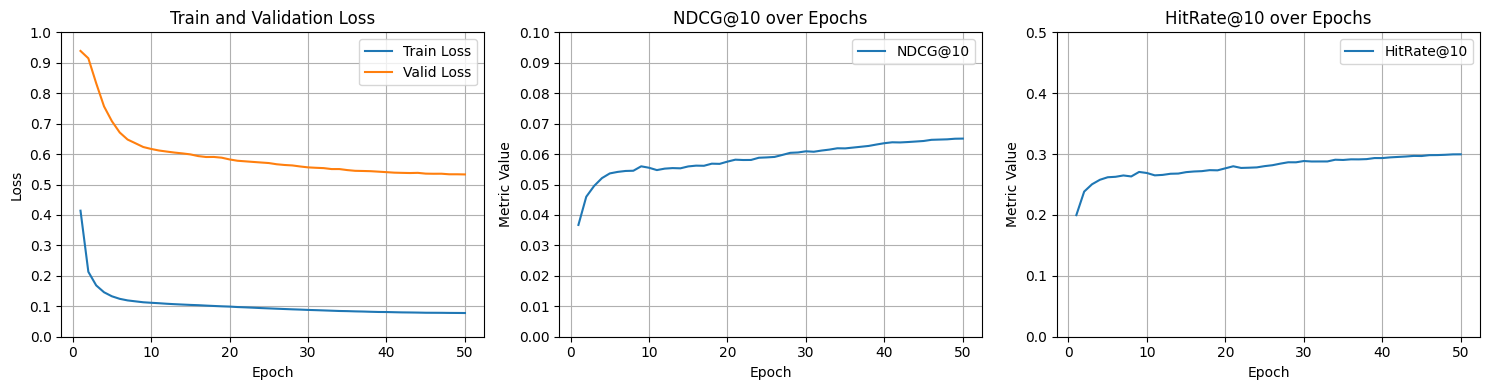

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))  # 1 hàng, 3 cột

# Create a range of epoch numbers for the x-axis
epochs_range = range(1, len(train_losses) + 1)

# --- Plot 1: Training and Validation Losses ---
axes[0].plot(epochs_range, train_losses, label='Train Loss')
axes[0].plot(epochs_range, valid_losses, label='Valid Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Train and Validation Loss')
axes[0].legend()
axes[0].grid(True)
axes[0].set_ylim(0.0, 1.0)
axes[0].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

# --- Plot 2: NDCG@10 over Epochs ---
axes[1].plot(epochs_range, ndcgs_10, label='NDCG@10')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Metric Value')
axes[1].set_title('NDCG@10 over Epochs')
axes[1].legend()
axes[1].grid(True)
axes[1].set_ylim(0.00, 0.1)
axes[1].set_yticks([0.00, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])

# --- Plot 3: HitRate@10 over Epochs ---
axes[2].plot(epochs_range, hitrates_10, label='HitRate@10')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Metric Value')
axes[2].set_title('HitRate@10 over Epochs')
axes[2].legend()
axes[2].grid(True)
axes[2].set_ylim(0.0, 0.5)
axes[2].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5])

plt.tight_layout()
plt.show()

# **6. Đánh giá khả năng xếp hạng (ranking)**

In [23]:
model = NGCF(
    num_users = num_users,
    num_items = num_games,
    embedding_dim = 64,
    num_layers = 3,
    mess_dropout_prob = 0.2,
    node_dropout_prob = 0.4
)

# Load model with proper device mapping
model.load_state_dict(torch.load(model_dir, map_location=device))
model.to(device)  # Move model to appropriate device

NGCF(
  (embedding): Embedding(51906, 64)
  (convs): ModuleList(
    (0-2): 3 x NGCFConv()
  )
)

In [24]:
def create_test_data(dataset_df, train_df, test_df, device, min_unplayed=9):
    # Create game list and mappings
    game_list = sorted(dataset_df["app_id"].unique())
    game2idx = {game_id: idx for idx, game_id in enumerate(game_list)}
    num_games_filtered = len(game_list)

    # Identify warm-start and cold-start users
    train_user_ids = set(train_df["user_id"])
    test_user_ids = set(test_df["user_id"])
    warm_user_ids = sorted(train_user_ids & test_user_ids)
    cold_user_ids = sorted(test_user_ids - train_user_ids)
    all_test_user_ids = warm_user_ids + cold_user_ids
    user2idx = {user_id: idx for idx, user_id in enumerate(all_test_user_ids)}

    # Track interacted games for warm-start users (train)
    user_played_games = defaultdict(set)
    for user_id, game_id in zip(train_df["user_id"], train_df["app_id"]):
        if user_id in user2idx:
            user_played_games[user_id].add(game_id)

    # Track test interactions for all users
    user_test = defaultdict(list)
    for user_id, game_id, label in zip(test_df["user_id"], test_df["app_id"], test_df["is_recommended"]):
        user_test[user_id].append((game_id, label))

    # Initialize tensors
    num_test_users = len(all_test_user_ids)
    test_labels = torch.zeros((num_test_users, num_games_filtered), dtype=torch.float, device=device)
    has_interacted_masks = torch.zeros((num_test_users, num_games_filtered), dtype=torch.bool, device=device)

    # Fill tensors
    for user_id in all_test_user_ids:
        u_idx = user2idx[user_id]
        for game_id, label in user_test[user_id]:
            if game_id in game2idx:
                test_labels[u_idx, game2idx[game_id]] = float(label)
        for game_id in user_played_games.get(user_id, []):
            if game_id in game2idx:
                has_interacted_masks[u_idx, game2idx[game_id]] = True

    # Filter users with too few unplayed games
    good_users = []
    for user_id in all_test_user_ids:
        played = user_played_games.get(user_id, set())
        positives = {g for g, l in user_test[user_id] if l == 1}
        unplayed = set(game_list) - played - positives
        if len(unplayed) >= min_unplayed:
            good_users.append(user_id)

    keep_indices = [user2idx[u] for u in good_users]
    test_labels = test_labels[keep_indices]
    has_interacted_masks = has_interacted_masks[keep_indices]
    warm_users_mask = torch.tensor([u in train_user_ids for u in good_users],
                                   dtype=torch.bool, device=device)
    user_ids_tensor = torch.tensor(good_users, dtype=torch.long, device=device)

    # Create mask for warm-start items
    train_items = set(train_df["app_id"])
    warm_items_mask = torch.tensor([g in train_items for g in game_list],
                                   dtype=torch.bool, device=device)

    return Data(
        labels=test_labels,
        has_interacted_masks=has_interacted_masks,
        user_ids=user_ids_tensor,
        warm_items_mask=warm_items_mask,
        warm_users_mask=warm_users_mask,
        game_list=game_list
    )

test_data = create_test_data(dataset, train_df, test_df, device)

In [25]:
@torch.no_grad()
def evaluate_ranking_full_corpus(model, test_data, device, k=10, batch_size = 4096):
    print("Evaluating ranking metrics on full corpus...")
    model.eval()

    # Get embeddings
    emb = model.embedding.weight
    num_users = model.num_users
    item_emb = emb[num_users:]

    # Get test data
    test_labels = test_data.labels
    has_interacted_masks = test_data.has_interacted_masks
    user_ids = test_data.user_ids
    warm_items_mask = test_data.warm_items_mask
    warm_users_mask = test_data.warm_users_mask

    # Precompute item embedding parts
    warm_item_emb = item_emb[warm_items_mask]

    # Metrics storage
    all_prec = []
    all_recall = []
    all_ndcg = []
    all_hit = []

    num_test = user_ids.size(0)

    # Process in batches
    for start in tqdm(range(0, num_test, batch_size), desc="Evaluating", leave=False):
        end = min(start + batch_size, num_test)
        batch_idx = slice(start, end)
        batch_user_ids = user_ids[batch_idx]
        batch_warm_mask = warm_users_mask[batch_idx]

        # Initialize scores for all users with zeros
        batch_scores = torch.zeros((end-start, test_labels.size(1)), device=device)

        # Compute scores only for warm-start users
        if batch_warm_mask.any():
            warm_user_indices = torch.where(batch_warm_mask)[0]
            warm_user_ids = batch_user_ids[warm_user_indices]

            # Get embeddings for warm users
            warm_u_emb = emb[warm_user_ids]

            # Compute scores for warm items
            warm_scores = warm_u_emb @ warm_item_emb.T

            # Place warm item scores in the correct positions
            for i, orig_idx in enumerate(warm_user_indices):
                batch_scores[orig_idx, warm_items_mask] = warm_scores[i]

        # Mask scores for already interacted items
        batch_scores = batch_scores.masked_fill(has_interacted_masks[batch_idx], -float('inf'))
        batch_labels = test_labels[batch_idx]

        # Skip users with no positive labels
        valid_users = batch_labels.sum(dim=1) > 0
        if not valid_users.any():
            continue

        batch_scores = batch_scores[valid_users]
        batch_labels = batch_labels[valid_users]

        # Compute metrics
        prec = precision_at_k(batch_scores, batch_labels, k)
        recall = recall_at_k(batch_scores, batch_labels, k)
        ndcg = ndcg_at_k(batch_scores, batch_labels, k)
        hitrate = hitrate_at_k(batch_scores, batch_labels, k)

        all_prec.append(prec)
        all_recall.append(recall)
        all_ndcg.append(ndcg)
        all_hit.append(hitrate)

    # Compute average metrics
    all_prec = torch.cat(all_prec).mean().item() if all_prec else 0.0
    all_recall = torch.cat(all_recall).mean().item() if all_recall else 0.0
    all_ndcg = torch.cat(all_ndcg).mean().item() if all_ndcg else 0.0
    all_hit = torch.cat(all_hit).mean().item() if all_hit else 0.0

    return {
        f"Precision@{k}": all_prec,
        f"Recall@{k}": all_recall,
        f"NDCG@{k}": all_ndcg,
        f"HitRate@{k}": all_hit,
    }

# Đánh giá dựa trên full corpus
full_corpus_result = evaluate_ranking_full_corpus(model, test_data, device)
print("\n--- Full Corpus Ranking Metrics ---")
for metric, value in full_corpus_result.items():
    print(f"{metric}: {value:.4f}")

Evaluating ranking metrics on full corpus...



--- Full Corpus Ranking Metrics ---
Precision@10: 0.0256
Recall@10: 0.0299
NDCG@10: 0.0330
HitRate@10: 0.1906
